actual params 0.43599490214200376 0.025926231827891333
tau 1: 5.496624778787091 tau 2: 4.3532239261827685
trf :
params [0.90551718 0.05384615]
actual ratio: 16.816747803395103 predicted ratio: 16.8167477222452
MSE 2.2886026826128045e-22 



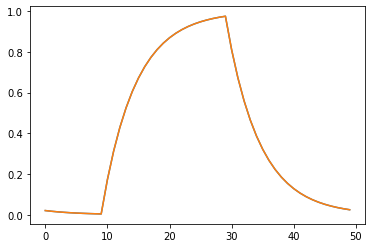

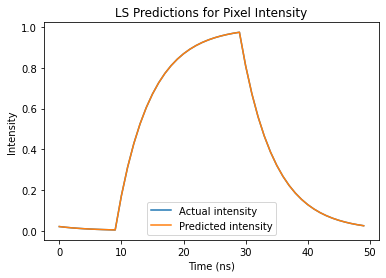

dogbox :
params [1.         0.05946453]
actual ratio: 16.816747803395103 predicted ratio: 16.81674814000896
MSE 3.937870939540098e-21 



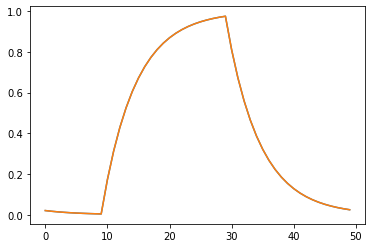

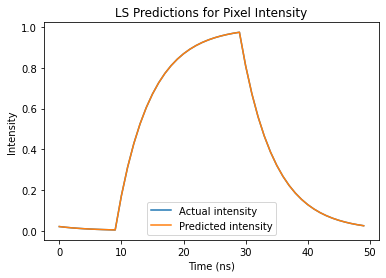

In [11]:
# Author: Hannah (but mostly used Franz file Franz_test_deconvolution _2)
# 5/5/22
# Fits an exponential model to a two-particle single pixel with known lifetimes.

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

np.random.seed(2) # set seed during development and testing of code

# constants
TIME_RANGE = 50
TAU_RANGE = 10
TIME_INTERVAL = 1   #howmany ns per timestep
HEAVISIDE_START = 10
HEAVISIDE_LENGTH = 20   #in ns

A1 = np.random.random()
A2 = np.random.random()

TAU_1 = TAU_RANGE * np.random.random()
TAU_2 = TAU_RANGE * np.random.random()
# TAU_1 = TAU_RANGE * np.random.random() + 0.2
# TAU_2 = TAU_RANGE * np.random.random() + 0.8
SAMPLING_FACTOR = 2

# performs convolution
def conv(a,b):
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    C = A * B
    return abs(np.fft.ifft(C)/np.sum(a))

# performs deconvolution
def deconv(a,b):
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    return abs(np.fft.ifft(A/B))

# single exponential decay
def decay_func(t, b):
    z = np.exp(-(t)/ b)
    z[0] = 0
    return z

# given parameter estimates, finds intensity value before convolution
def multiexp(t, a1, a2):
  return a1 * np.exp(- (t- HEAVISIDE_START + 1) / TAU_1) + a2 * np.exp(-(t- HEAVISIDE_START + 1) / TAU_2)
  # return a1 * np.exp(- (t) / TAU_1) + a2 * np.exp(-(t) / TAU_2)

# combined function of exponential and convolution that produces intensities
def function(inputs, a1, a2):
  # print("testing with a1", a1, "and a2", a2)
  guess = multiexp(inputs[:,0], a1, a2)
  est = conv(guess, inputs[:,1])
  return est
  
# uses nonlinear least squares to fit parameters to the function
def nonlin_least_squares(method, inputs, I):
  init_a = np.random.rand(2)
  # init_a = (0.5, 0.5)
  params = curve_fit(function, inputs, I, p0=init_a, method=method, bounds=(0, 1), verbose=0)
  return params

# creates data points for the heaviside irf
def heaviside_irf(t, irf_start):
    irf = np.zeros(len(t))
    irf[irf_start:irf_start+HEAVISIDE_LENGTH] = 1
    return irf

# simulates intensities values for a pixel
def simulate_pixel(irf_start):
    print("actual params", A1, A2)
    t_values = np.arange(0, TIME_RANGE,TIME_INTERVAL)
    # decay_1 = decay_func(t_values, TAU_1)
    # decay_2 = decay_func(t_values, TAU_2)
    # irf = heaviside_irf(t_values, irf_start)
    # decay_total = A1 * decay_1 + A2 * decay_2
    # data = conv(decay_total, irf)
    IRF = heaviside_irf(t_values, irf_start)
    inputs = np.stack((t_values, IRF), axis=1)
    intensities = function(inputs, A1, A2)
    # return(decay_total, irf, data)
    return(IRF, intensities)


def main():
  # modeling data
  t = np.arange(0, TIME_RANGE,TIME_INTERVAL)
  # (decay_total, IRF, I) = simulate_pixel(HEAVISIDE_START)
  (IRF, I) = simulate_pixel(HEAVISIDE_START)
  inputs = np.stack((t, IRF), axis=1)
  print("tau 1:", TAU_1, "tau 2:", TAU_2)

  # try multiple curve-fitting methods and report mse
  for method in ['trf', 'dogbox']:
    print(method, ":")
    model = nonlin_least_squares(method, inputs, I)[0]
    print("params", model)
    print("actual ratio:", A1/A2, "predicted ratio:", model[0]/model[1])
    est = function(inputs, model[0], model[1])
    intensities = function(inputs, A1, A2)
    mse = ((est - I)**2).mean()
    print("MSE", mse, '\n')

    plt.plot(I)
    plt.plot(est)
    # plt.plot(IRF)

    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Intensity')
    ax2.set_title('LS Predictions for Pixel Intensity')
    plt.plot(I, label="Actual intensity")
    plt.plot(est, label="Predicted intensity")
    ax2.legend()
    plt.show()

  # try on smaller datasets to report effect on accuracy
  # small_inputs = inputs[::SAMPLING_FACTOR]
  # small_I = I[::SAMPLING_FACTOR]
  # for method in ['trf', 'dogbox']:
  #   print(method, " small dataset:")
  #   model = nonlin_least_squares(method, small_inputs, small_I)[0]
  #   print("params", model)
  #   est = function(small_inputs, model[0], model[1])
  #   mse = ((est - small_I)**2).mean()
  #   print("MSE", mse, '\n')

  #   plt.plot(small_I)
  #   plt.plot(est)
  #   # plt.plot(IRF)
  #   plt.show()

main()

actual params 0.22199317108973948 0.8707323061773764
a1 =  0.6514581068642686
a2 =  2.6917126617187166
MSE = 9.967257472171707e-06


(0.6514581068642686, 2.6917126617187166, 9.967257472171707e-06)

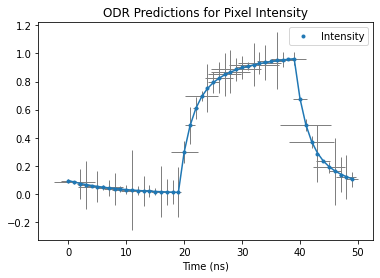

In [9]:
#fit with an orthogonal distance regression (ODR) using scipy.odr
from scipy.odr import ODR, Model, Data, RealData
import pandas as pd
from numpy import linspace, random

#modelling data
t = np.arange(0, TIME_RANGE,TIME_INTERVAL)
(IRF, I) = simulate_pixel(HEAVISIDE_LENGTH)

#add some uncertainties
num = len(t)
dt = [np.random.normal(1, 2) for i in range(num)]
dI = [np.random.normal(0.05, 0.1) for i in range(num)]

def target_function(a, t):
    a1, a2 = a
    guess = multiexp(t, a1, a2)
    #add some noise
    #noise = random.normal(size=t.size, scale=0.1)
    #return conv(guess, IRF) + noise
    return conv(guess, IRF)

def odr_fit():
    data = RealData(t, I, dt, dI)
    model = Model(target_function)
    #model fitting
    odr_model = ODR(data, model, beta0=[0.7, 0.3])
    odr_model.set_job(fit_type=0)
    odr_output = odr_model.run()

    #if convergence is not reached, run again the algorithm
    if odr_output.info != 1:
        i = 1
        while odr_output.info != 1 and i < 100:
            odr_output = odr_model.restart()
            i += 1
    
    #print the results
    a1, a2 = odr_output.beta
    print("a1 = ", a1)
    print("a2 = ", a2)
    pred = target_function(odr_output.beta, t)
    mse = ((pred - I)**2).mean()
    print("MSE =", mse)

    #plot the results
    dataset = pd.DataFrame({'Time (ns)': t, 'Intensity': I, 'dx': dt, 'dy': dI})
    ax = dataset.plot(
    x="Time (ns)", y="Intensity",
    kind="line", yerr="dy", xerr="dx",
    title="ODR Predictions for Pixel Intensity",
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
    )
    ax.plot(t, pred)
    return a1, a2, mse

odr_fit()
